### FAKE NEWS CLASSIFICATION USING LOGISTIC REGRESSION

#### IMPORTING REQUIRED LIBRARIES

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string 
import re 
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
raw_fake = pd.read_csv('Fake.csv')
raw_true = pd.read_csv('True.csv')

### DATA CLEANING

In [3]:
# Creating a new attribute named 'target' to differentiate between fake news(0) and true news(1).
raw_fake['target'] = 0
raw_true['target'] = 1

In [4]:
raw_fake.head

<bound method NDFrame.head of                                                    title   
0       Donald Trump Sends Out Embarrassing New Year’...  \
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject   
0      Donald Trump just couldn t wish all Americans ...         News  \
1      House Intelligence Committee Chairman Devin Nu...         News   
2      On Friday, it was revea

In [5]:
raw_true.head

<bound method NDFrame.head of                                                    title   
0      As U.S. budget fight looms, Republicans flip t...  \
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
21412  'Fully committed' NATO backs new U.S. approach...   
21413  LexisNexis withdrew two products from Chinese ...   
21414  Minsk cultural hub becomes haven from authorities   
21415  Vatican upbeat on possibility of Pope Francis ...   
21416  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text       subject   
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews  \
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters)

In [6]:
#Merging both the datasets into one single dataframe for data cleaning process
df = pd.concat([raw_fake,raw_true], ignore_index=True)

In [7]:
df.head

<bound method NDFrame.head of                                                    title   
0       Donald Trump Sends Out Embarrassing New Year’...  \
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
44893  'Fully committed' NATO backs new U.S. approach...   
44894  LexisNexis withdrew two products from Chinese ...   
44895  Minsk cultural hub becomes haven from authorities   
44896  Vatican upbeat on possibility of Pope Francis ...   
44897  Indonesia to buy $1.14 billion worth of Russia...   

                                                    text    subject   
0      Donald Trump just couldn t wish all Americans ...       News  \
1      House Intelligence Committee Chairman Devin Nu...       News   
2      On Friday, it was revealed th

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   target   44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [9]:
df.describe()

,target
count,44898.000000
mean,0.477015
std,0.499477
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


#### Checking for null values

In [10]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

#### Checking for duplicates

In [11]:
df.duplicated().sum()

209

In [12]:
#Dropping the duplicate values in the data and just keeping their first occurrence 
df = df.drop_duplicates(keep = 'first')

In [13]:
df.duplicated().sum()

0

In [14]:
df.shape

(44689, 5)

In [15]:
df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [16]:
df['target'].value_counts()

target
0    23478
1    21211
Name: count, dtype: int64

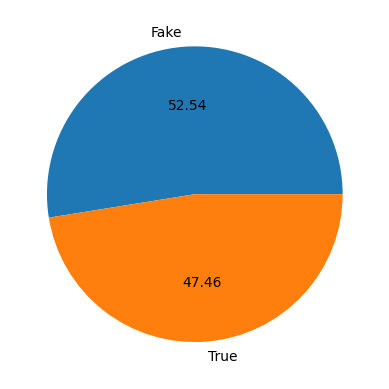

In [17]:
#Checking the distribution of fake and true news data present
plt.pie(df['target'].value_counts(), labels = ['Fake','True'], autopct = "%0.2f")
plt.show()

In [18]:
#Merging the title and text attributes into content to make the modelling convenient
df['content'] = df['title'] +' '+ df['text']
print(df['content'])

0         Donald Trump Sends Out Embarrassing New Year’...
1         Drunk Bragging Trump Staffer Started Russian ...
2         Sheriff David Clarke Becomes An Internet Joke...
3         Trump Is So Obsessed He Even Has Obama’s Name...
4         Pope Francis Just Called Out Donald Trump Dur...
                               ...                        
44893    'Fully committed' NATO backs new U.S. approach...
44894    LexisNexis withdrew two products from Chinese ...
44895    Minsk cultural hub becomes haven from authorit...
44896    Vatican upbeat on possibility of Pope Francis ...
44897    Indonesia to buy $1.14 billion worth of Russia...
Name: content, Length: 44689, dtype: object


C:\Users\appur\AppData\Local\Temp\ipykernel_3344\2870692072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['title'] +' '+ df['text']


In [19]:
df.head()

,title,text,subject,date,target,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...


#### - Stemming
#### - Lower 

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\appur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### DATA PREPROCESSING
1. Lower case
2. Tokenizing the words
3. Removing stopwords and punctuations


In [21]:
ps = PorterStemmer()

In [22]:
def transform_text(content):
    content = content.lower()
    content = nltk.word_tokenize(content)
    
    y = []
    for i in content:
        if i.isalnum():
            y.append(i)
    
    content = y[:]
    y.clear()
    
    for i in content:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    content = y[:]
    y.clear()
    
    for i in content:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [23]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [24]:
ps.stem('loving')

'love'

In [25]:
df.head()

,title,text,subject,date,target,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Sheriff David Clarke Becomes An Internet Joke...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Trump Is So Obsessed He Even Has Obama’s Name...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Pope Francis Just Called Out Donald Trump Dur...


In [27]:
# Applying the the function to the 'content' attribute
df['content'] = df['content'].progress_apply(transform_text)

  0%|          | 0/44689 [00:00<?, ?it/s]

C:\Users\appur\AppData\Local\Temp\ipykernel_3344\1893285111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].progress_apply(transform_text)


In [28]:
df['content']

0        donald trump send embarrass new year eve messa...
1        drunk brag trump staffer start russian collus ...
2        sheriff david clark becom internet joke threat...
3        trump obsess even obama name code websit imag ...
4        pope franci call donald trump christma speech ...
                               ...                        
44893    commit nato back new approach afghanistan brus...
44894    lexisnexi withdrew two product chines market l...
44895    minsk cultur hub becom author minsk reuter sha...
44896    vatican upbeat possibl pope franci visit russi...
44897    indonesia buy billion worth russian jet jakart...
Name: content, Length: 44689, dtype: object

In [30]:
df.head(20)

,title,text,subject,date,target,content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,donald trump send embarrass new year eve messa...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,drunk brag trump staffer start russian collus ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,sheriff david clark becom internet joke threat...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,trump obsess even obama name code websit imag ...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,pope franci call donald trump christma speech ...
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0,racist alabama cop brutal black boy handcuff g...
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0,fresh golf cours trump lash fbi deputi directo...
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0,trump said insan racist stuff insid oval offic...
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0,former cia director slam trump un bulli openli...
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0,watch ad featur much kiss make sick might thou...


In [32]:
x = df['content'].values
y = df['target'].values

In [35]:
print(x)

['donald trump send embarrass new year eve messag disturb donald trump wish american happi new year leav instead give shout enemi hater dishonest fake news media former realiti show star one job countri rapidli grow stronger smarter want wish friend support enemi hater even dishonest fake news media happi healthi new year presid angri pant tweet 2018 great year america countri rapidli grow stronger smarter want wish friend support enemi hater even dishonest fake news media happi healthi new year 2018 great year america donald trump realdonaldtrump decemb 31 2017trump tweet went welll kind presid send new year greet like despic petti infantil gibberish trump lack decenc even allow rise gutter long enough wish american citizen happi new year bishop talbert swan talbertswan decemb 31 2017no one like calvin calvinstowel decemb 31 2017your impeach would make 2018 great year america also accept regain control congress miranda yaver mirandayav decemb 31 2017do hear talk includ mani peopl hate

In [36]:
print(y)

[0 0 0 ... 1 1 1]


In [41]:
# Measure Inverse Document Frequency (idf) to know the frequency of each words in the dataset
x = TfidfVectorizer().fit_transform(x)
print(x)

  (0, 35850)	0.017651128830879017
  (0, 7427)	0.03474110099674763
  (0, 47882)	0.026051389152298158
  (0, 81093)	0.02771865517310396
  (0, 58526)	0.02011603545997297
  (0, 31029)	0.022634441968078685
  (0, 16261)	0.04031296485921946
  (0, 73460)	0.0178507573386129
  (0, 34462)	0.03938631717297414
  (0, 78830)	0.018541429750475947
  (0, 2998)	0.05142542397290898
  (0, 60529)	0.07758315868193418
  (0, 54276)	0.027641930773725912
  (0, 28926)	0.0415752347742455
  (0, 79807)	0.07758315868193418
  (0, 79796)	0.052744108453631935
  (0, 72853)	0.024487103466357598
  (0, 72626)	0.038949234109561734
  (0, 7935)	0.03326647558007355
  (0, 73119)	0.07758315868193418
  (0, 65457)	0.049292477995101135
  (0, 63552)	0.04142826448612295
  (0, 13390)	0.025186449565209892
  (0, 27484)	0.05024212038807703
  (0, 42723)	0.015102770108703029
  :	:
  (44688, 26383)	0.036318846043510496
  (44688, 28183)	0.03445075371772044
  (44688, 51618)	0.04826911643938173
  (44688, 21394)	0.0515065499332313
  (44688, 26089

In [60]:
#Splitting the dataset into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 2)

In [61]:
#Training the Logistic Regression model with the dataset
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [62]:
x.shape

(44689, 82755)

In [63]:
y.shape

(44689,)

In [64]:
#Checking the accuracy of the training data predictions
x_train_prediction = model.predict(x_train)
training_accuracy = accuracy_score(x_train_prediction, y_train)

In [65]:
print(training_accuracy)

0.9911890576487371


In [66]:
#Checking the accuracy of the test data predictions
x_test_prediction = model.predict(x_test)
test_accuracy = accuracy_score(x_test_prediction, y_test)

In [67]:
print(test_accuracy)

0.9847840680241665


In [71]:
x_sample = x_test[0]

In [72]:
prediction = model.predict(x_sample)
if prediction == 0:
    print('The news is REAL.')
else:
    print('The news is FAKE.')

The news is FAKE.
